## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For fetching economic data
try:
    import pandas_datareader as pdr
    from pandas_datareader import data as web
    print("pandas_datareader imported successfully")
except ImportError:
    print("pandas_datareader not found. Installing...")
    import sys
    !{sys.executable} -m pip install pandas-datareader
    import pandas_datareader as pdr
    from pandas_datareader import data as web
    print("pandas_datareader installed and imported")

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

pandas_datareader imported successfully
Libraries imported successfully!


## 2. Load Stock Data

In [3]:
# Load existing stock data and performance metrics
sector_df = pd.read_csv('sector_stocks.csv')
performance_df = pd.read_csv('stock_performance_summary.csv')

# Load price data
price_data = pd.read_pickle('price_data_all_stocks_cache.pkl')

print(f"Stocks loaded: {len(sector_df)}")
print(f"Performance data: {len(performance_df)}")
print(f"Price data shape: {price_data.shape}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")

Stocks loaded: 302
Performance data: 302
Price data shape: (500, 1535)
Date range: 2023-12-08 00:00:00 to 2025-12-05 00:00:00


In [4]:
# Extract Close prices and calculate aggregate sector indices
if isinstance(price_data.columns, pd.MultiIndex):
    adj_close = price_data.xs('Close', level=0, axis=1)
else:
    adj_close = price_data

# Remove all-NaN columns
adj_close = adj_close.dropna(axis=1, how='all')

print(f"Clean price data shape: {adj_close.shape}")
print(f"Valid stocks: {len(adj_close.columns)}")

# Calculate sector-level price indices
sector_indices = {}
for sector in sector_df['Sector_Code'].unique():
    sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].tolist()
    # Get stocks that exist in our price data
    available_stocks = [s for s in sector_stocks if s in adj_close.columns]
    if available_stocks:
        sector_indices[sector] = adj_close[available_stocks].mean(axis=1)

sector_index_df = pd.DataFrame(sector_indices)
print(f"\nSector indices created for: {list(sector_indices.keys())}")
sector_index_df.head()

Clean price data shape: (500, 301)
Valid stocks: 301

Sector indices created for: ['XLK', 'XLV', 'XLF', 'XLI', 'XLY']


,XLK,XLV,XLF,XLI,XLY
Date,,,,,
2023-12-08,212.496640,218.455827,145.718108,190.787454,383.695363
2023-12-11,216.299903,220.563757,147.401650,192.695633,386.554268
2023-12-12,217.794654,222.109978,148.609445,193.762702,388.713483
2023-12-13,219.978599,228.394082,150.719620,196.199953,395.504629
2023-12-14,220.326419,229.227991,151.134988,198.932357,401.498259


## 3. Fetch Economic Data

We'll use FRED (Federal Reserve Economic Data) via pandas_datareader to fetch key economic indicators.

In [5]:
# Define date range matching our stock data
start_date = price_data.index[0]
end_date = price_data.index[-1]

print(f"Fetching economic data from {start_date} to {end_date}")

# FRED data series codes
fred_series = {
    'M2': 'M2SL',                    # M2 Money Supply
    'FED_FUNDS': 'FEDFUNDS',         # Federal Funds Rate
    'GDP': 'GDP',                    # GDP (Quarterly)
    'CPI': 'CPIAUCSL',               # Consumer Price Index
    'UNEMPLOYMENT': 'UNRATE',        # Unemployment Rate
    'TREASURY_10Y': 'DGS10',         # 10-Year Treasury Yield
    'TREASURY_2Y': 'DGS2',           # 2-Year Treasury Yield
}

print("\nEconomic indicators to fetch:")
for name, code in fred_series.items():
    print(f"  - {name}: {code}")

Fetching economic data from 2023-12-08 00:00:00 to 2025-12-05 00:00:00

Economic indicators to fetch:
  - M2: M2SL
  - FED_FUNDS: FEDFUNDS
  - GDP: GDP
  - CPI: CPIAUCSL
  - UNEMPLOYMENT: UNRATE
  - TREASURY_10Y: DGS10
  - TREASURY_2Y: DGS2


In [8]:
# Fetch economic data from FRED
import os
economic_cache = 'economic_data_cache.pkl'

if os.path.exists(economic_cache):
    print(f"Loading cached economic data from '{economic_cache}'...")
    economic_data = pd.read_pickle(economic_cache)
    print(f"Loaded economic data shape: {economic_data.shape}")
    print(f"Cached data includes: {economic_data.columns.tolist()}")
else:
    print("Fetching economic data from FRED...\n")
    economic_data = pd.DataFrame()
    
    for name, series_code in fred_series.items():
        try:
            print(f"Fetching {name} ({series_code})...")
            data = web.DataReader(series_code, 'fred', start_date, end_date)
            economic_data[name] = data.iloc[:, 0]
            print(f"  ✓ {name}: {len(data)} data points")
        except Exception as e:
            print(f"  ✗ Error fetching {name}: {str(e)}")
    
    # Fetch VIX from Yahoo Finance
    print("\nFetching VIX (Volatility Index) from Yahoo Finance...")
    try:
        vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)['Close']
        vix.name = 'VIX'
        economic_data = economic_data.join(vix, how='outer')
        print(f"  ✓ VIX: {len(vix)} data points")
    except Exception as e:
        print(f"  ✗ Error fetching VIX: {str(e)}")
    
    # Save cache with VIX included
    economic_data.to_pickle(economic_cache)
    print(f"\nEconomic data (with VIX) cached to '{economic_cache}'")

print(f"\nEconomic data shape: {economic_data.shape}")
print(f"Date range: {economic_data.index[0]} to {economic_data.index[-1]}")
economic_data.head(10)

Loading cached economic data from 'economic_data_cache.pkl'...
Loaded economic data shape: (22, 7)
Cached data includes: ['M2', 'FED_FUNDS', 'GDP', 'CPI', 'UNEMPLOYMENT', 'TREASURY_10Y', 'TREASURY_2Y']

Economic data shape: (22, 7)
Date range: 2024-01-01 00:00:00 to 2025-10-01 00:00:00


,M2,FED_FUNDS,GDP,CPI,UNEMPLOYMENT,TREASURY_10Y,TREASURY_2Y
DATE,,,,,,,
2024-01-01,20773.1,5.33,28708.161,309.794,3.7,NaN,NaN
2024-02-01,20861.1,5.33,NaN,311.022,3.9,3.87,4.20
2024-03-01,20900.9,5.33,NaN,312.107,3.9,4.19,4.54
2024-04-01,20928.9,5.33,29147.044,313.016,3.9,4.33,4.72
2024-05-01,20989.4,5.33,NaN,313.140,4.0,4.63,4.96
2024-06-01,21053.0,5.33,NaN,313.131,4.1,NaN,NaN
2024-07-01,21084.2,5.33,29511.664,313.566,4.2,4.48,4.77
2024-08-01,21171.0,5.33,NaN,314.131,4.2,3.99,4.16
2024-09-01,21257.5,5.13,NaN,314.851,4.1,NaN,NaN


In [9]:
# VIX is now included in the cached economic data above
# This cell kept for reference but data is already loaded
print("VIX data already included in economic_data")
print(f"Economic data shape: {economic_data.shape}")
print(f"Columns: {economic_data.columns.tolist()}")
economic_data.tail()

VIX data already included in economic_data
Economic data shape: (22, 7)
Columns: ['M2', 'FED_FUNDS', 'GDP', 'CPI', 'UNEMPLOYMENT', 'TREASURY_10Y', 'TREASURY_2Y']


,M2,FED_FUNDS,GDP,CPI,UNEMPLOYMENT,TREASURY_10Y,TREASURY_2Y
DATE,,,,,,,
2025-06-01,21942.4,4.33,NaN,321.500,4.1,NaN,NaN
2025-07-01,22028.8,4.33,NaN,322.132,4.2,4.26,3.78
2025-08-01,22108.4,4.33,NaN,323.364,4.3,4.23,3.69
2025-09-01,22212.5,4.22,NaN,324.368,4.4,NaN,NaN
2025-10-01,22298.1,4.09,NaN,NaN,NaN,4.12,3.55


## 4. Data Processing and Feature Engineering

Missing values in economic data:
GDP             72.727273
TREASURY_10Y    40.909091
TREASURY_2Y     40.909091
CPI              4.545455
UNEMPLOYMENT     4.545455
M2               0.000000
FED_FUNDS        0.000000
dtype: float64


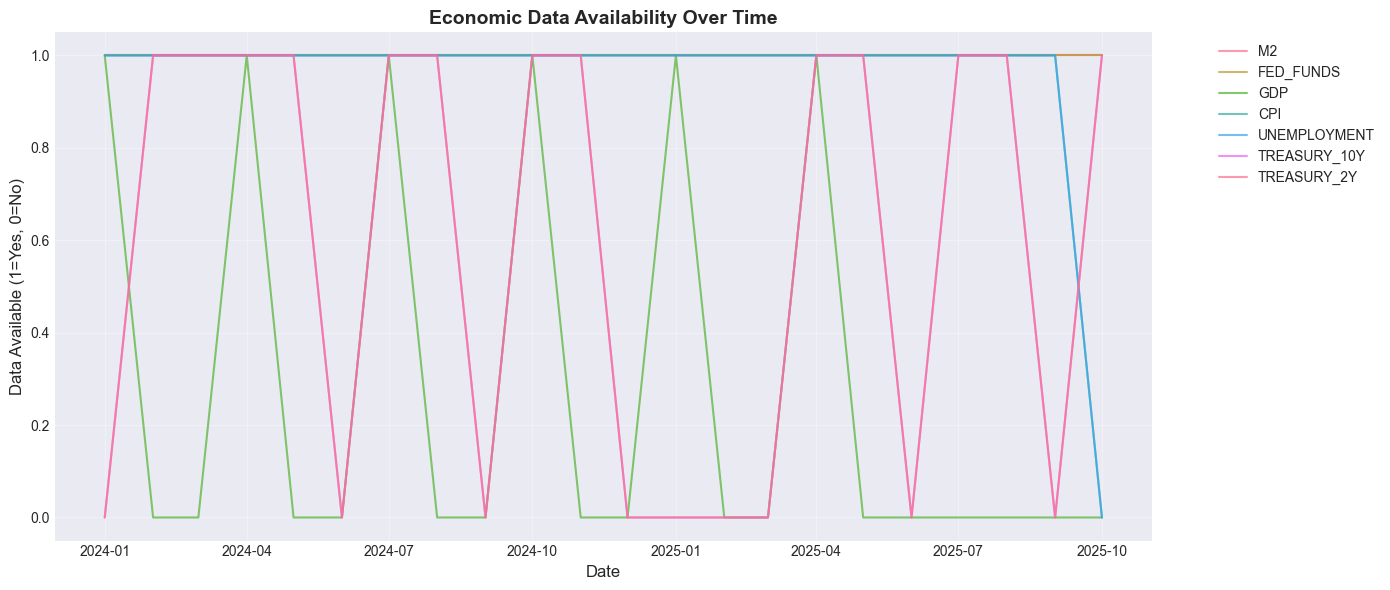

In [10]:
# Check data frequency and missing values
print("Missing values in economic data:")
missing_pct = (economic_data.isnull().sum() / len(economic_data) * 100).sort_values(ascending=False)
print(missing_pct)

# Visualize data availability
plt.figure(figsize=(14, 6))
for col in economic_data.columns:
    plt.plot(economic_data.index, economic_data[col].notna().astype(int), label=col, alpha=0.7)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Data Available (1=Yes, 0=No)', fontsize=12)
plt.title('Economic Data Availability Over Time', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Forward fill missing values (economic data is often released monthly/quarterly)
economic_data_filled = economic_data.fillna(method='ffill')

# Calculate changes and growth rates
economic_features = economic_data_filled.copy()

# M2 growth rate (year-over-year)
if 'M2' in economic_features.columns:
    economic_features['M2_YoY_Growth'] = economic_features['M2'].pct_change(252) * 100
    economic_features['M2_QoQ_Growth'] = economic_features['M2'].pct_change(63) * 100

# Inflation rate (year-over-year CPI change)
if 'CPI' in economic_features.columns:
    economic_features['Inflation_YoY'] = economic_features['CPI'].pct_change(252) * 100

# GDP growth (quarter-over-quarter)
if 'GDP' in economic_features.columns:
    economic_features['GDP_Growth'] = economic_features['GDP'].pct_change(63) * 100

# Yield curve slope (10Y - 2Y)
if 'TREASURY_10Y' in economic_features.columns and 'TREASURY_2Y' in economic_features.columns:
    economic_features['Yield_Curve_Slope'] = economic_features['TREASURY_10Y'] - economic_features['TREASURY_2Y']

# Federal Funds Rate change
if 'FED_FUNDS' in economic_features.columns:
    economic_features['FED_FUNDS_Change'] = economic_features['FED_FUNDS'].diff()

print("Economic features created:")
print(economic_features.columns.tolist())
print(f"\nShape: {economic_features.shape}")
economic_features.tail()

Economic features created:
['M2', 'FED_FUNDS', 'GDP', 'CPI', 'UNEMPLOYMENT', 'TREASURY_10Y', 'TREASURY_2Y', 'M2_YoY_Growth', 'M2_QoQ_Growth', 'Inflation_YoY', 'GDP_Growth', 'Yield_Curve_Slope', 'FED_FUNDS_Change']

Shape: (22, 13)


,M2,FED_FUNDS,GDP,CPI,UNEMPLOYMENT,TREASURY_10Y,TREASURY_2Y,M2_YoY_Growth,M2_QoQ_Growth,Inflation_YoY,GDP_Growth,Yield_Curve_Slope,FED_FUNDS_Change
DATE,,,,,,,,,,,,,
2025-06-01,21942.4,4.33,30485.729,321.500,4.1,4.25,3.70,NaN,NaN,NaN,NaN,0.55,0.00
2025-07-01,22028.8,4.33,30485.729,322.132,4.2,4.26,3.78,NaN,NaN,NaN,NaN,0.48,0.00
2025-08-01,22108.4,4.33,30485.729,323.364,4.3,4.23,3.69,NaN,NaN,NaN,NaN,0.54,0.00
2025-09-01,22212.5,4.22,30485.729,324.368,4.4,4.23,3.69,NaN,NaN,NaN,NaN,0.54,-0.11
2025-10-01,22298.1,4.09,30485.729,324.368,4.4,4.12,3.55,NaN,NaN,NaN,NaN,0.57,-0.13


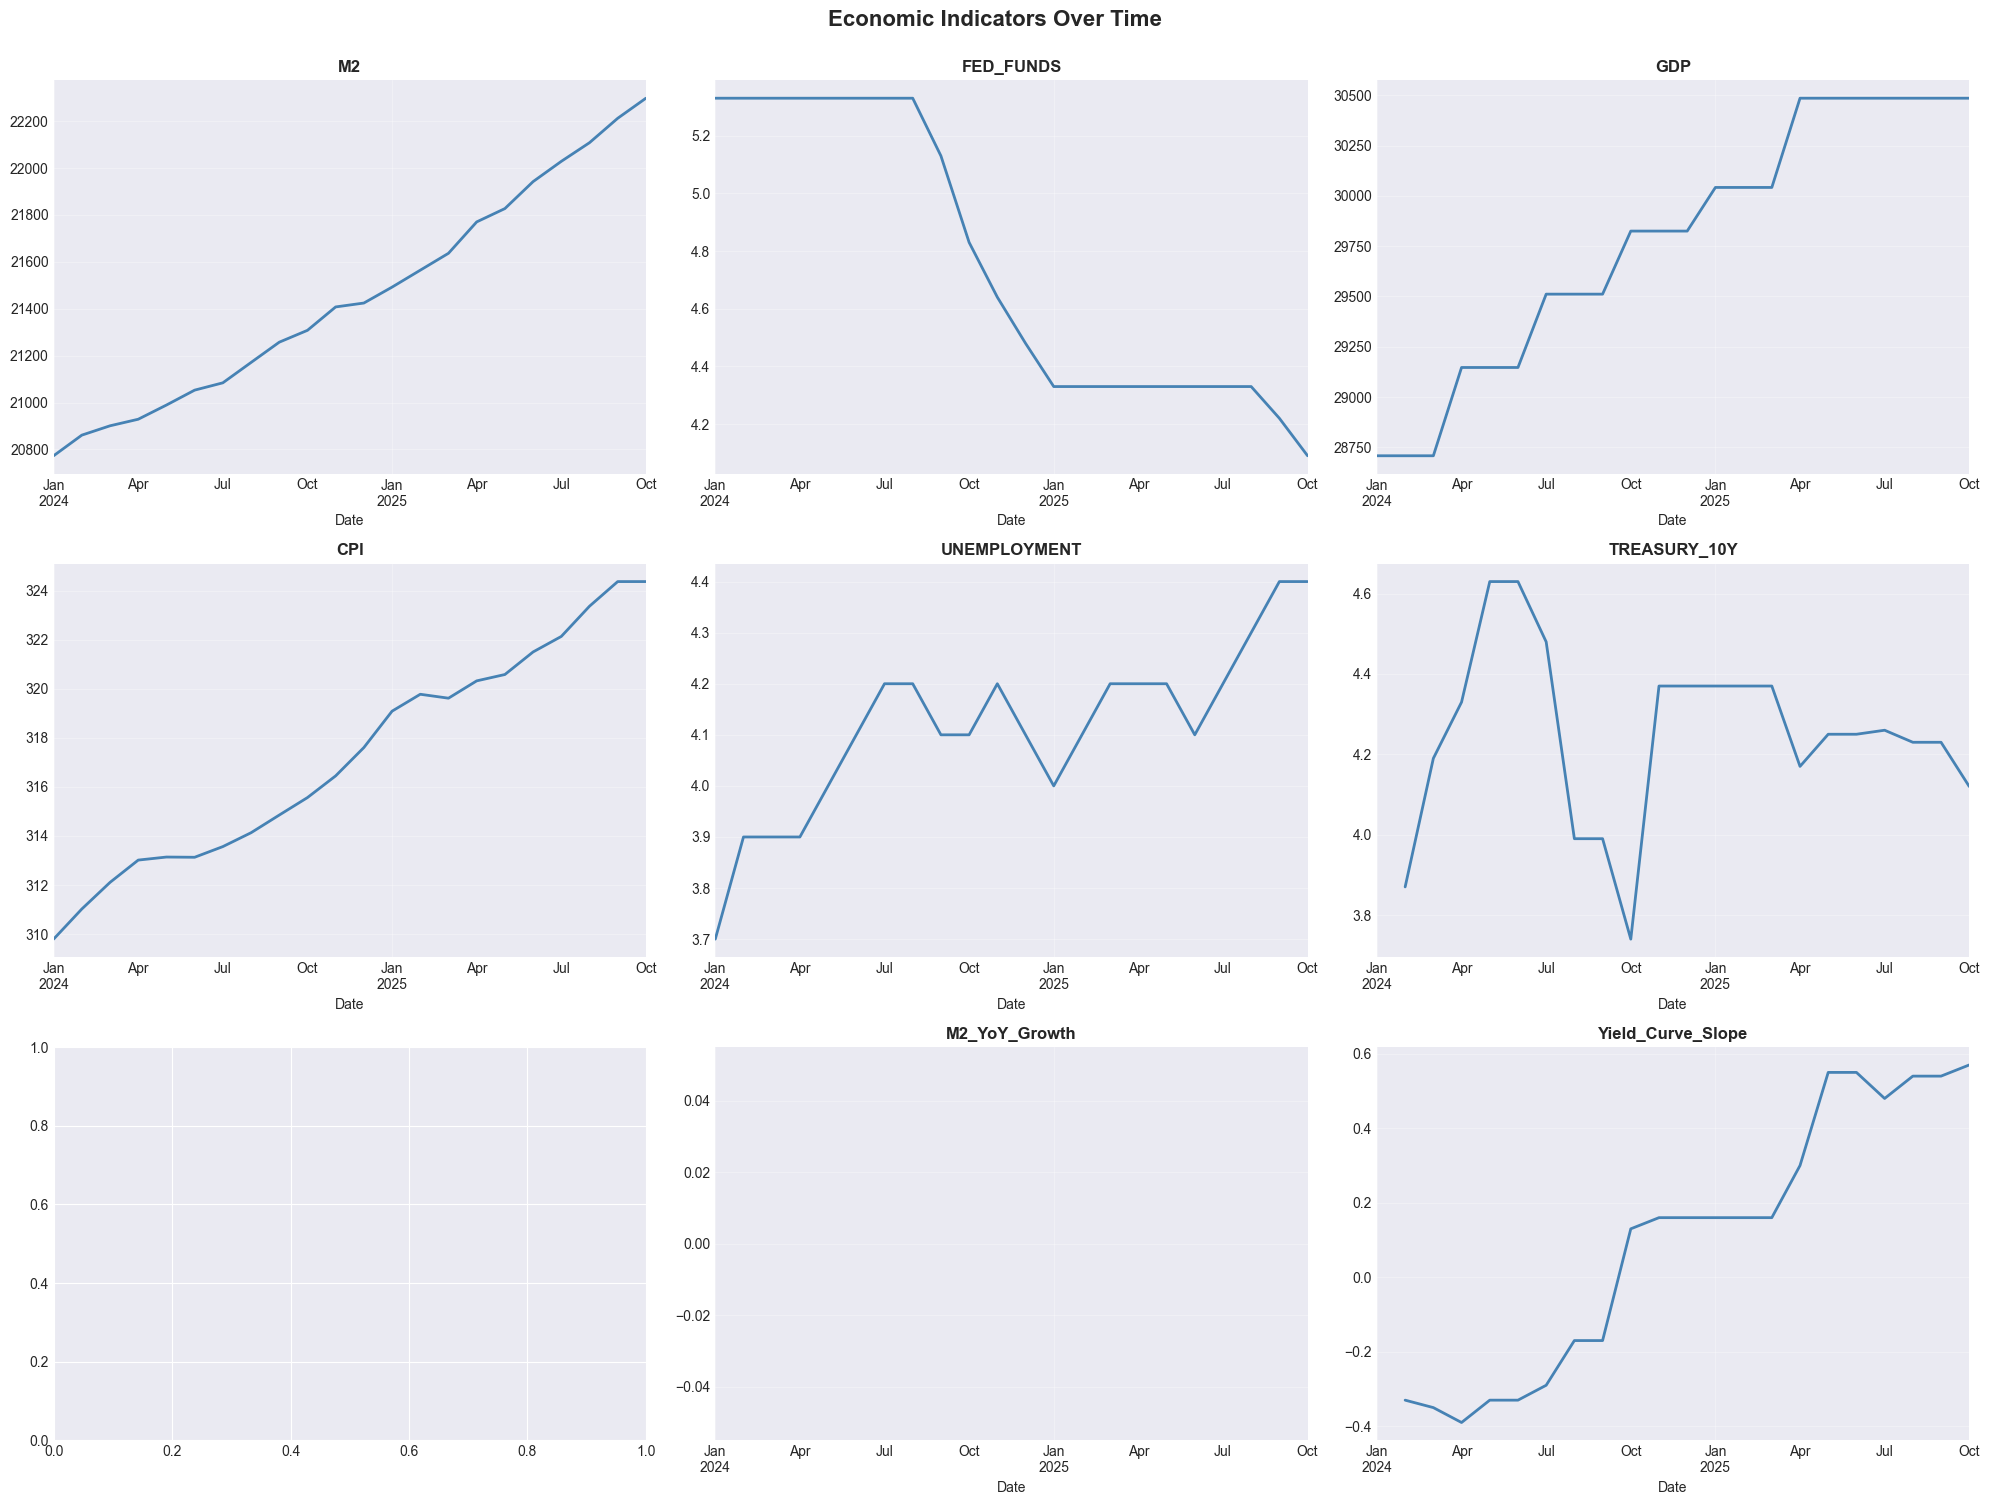

In [19]:
# Visualize economic indicators over time
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

indicators_to_plot = ['M2', 'FED_FUNDS', 'GDP', 'CPI', 'UNEMPLOYMENT', 
                      'TREASURY_10Y', 'VIX', 'M2_YoY_Growth', 'Yield_Curve_Slope']

for idx, indicator in enumerate(indicators_to_plot):
    if indicator in economic_features.columns:
        ax = axes[idx]
        economic_features[indicator].plot(ax=ax, linewidth=2, color='steelblue')
        ax.set_title(indicator, fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.grid(True, alpha=0.3)

plt.suptitle('Economic Indicators Over Time', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Align Stock and Economic Data

In [20]:
# Calculate stock returns (monthly and daily)
stock_returns_daily = adj_close.pct_change()
stock_returns_monthly = adj_close.resample('M').last().pct_change()

# Calculate sector returns
sector_returns_daily = sector_index_df.pct_change()
sector_returns_monthly = sector_index_df.resample('M').last().pct_change()

print(f"Daily stock returns shape: {stock_returns_daily.shape}")
print(f"Monthly stock returns shape: {stock_returns_monthly.shape}")
print(f"Daily sector returns shape: {sector_returns_daily.shape}")
print(f"Monthly sector returns shape: {sector_returns_monthly.shape}")

Daily stock returns shape: (500, 301)
Monthly stock returns shape: (25, 301)
Daily sector returns shape: (500, 5)
Monthly sector returns shape: (25, 5)


In [21]:
# Resample economic data to monthly frequency for easier analysis
economic_monthly = economic_features.resample('M').last()

# Align dates between stock returns and economic data
common_dates = stock_returns_monthly.index.intersection(economic_monthly.index)
print(f"Common dates for analysis: {len(common_dates)}")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

# Create aligned datasets
stock_returns_aligned = stock_returns_monthly.loc[common_dates]
sector_returns_aligned = sector_returns_monthly.loc[common_dates]
economic_aligned = economic_monthly.loc[common_dates]

print(f"\nAligned stock returns: {stock_returns_aligned.shape}")
print(f"Aligned sector returns: {sector_returns_aligned.shape}")
print(f"Aligned economic data: {economic_aligned.shape}")

Common dates for analysis: 22
Date range: 2024-01-31 00:00:00 to 2025-10-31 00:00:00

Aligned stock returns: (22, 301)
Aligned sector returns: (22, 5)
Aligned economic data: (22, 13)


## 6. Correlation Analysis: Economic Factors vs Stock Returns

In [22]:
# Calculate average market return (equal-weighted)
market_return = stock_returns_aligned.mean(axis=1)
market_return.name = 'Market_Return'

# Combine market return with economic data
analysis_df = pd.concat([market_return, economic_aligned], axis=1)

# Check for NaN values before dropping
print("NaN counts before cleaning:")
print(analysis_df.isnull().sum())
print(f"\nOriginal shape: {analysis_df.shape}")

# Only drop rows where Market_Return is NaN (keep rows with some economic data missing)
analysis_df = analysis_df[analysis_df['Market_Return'].notna()]

# For remaining columns, fill forward any missing economic data
analysis_df = analysis_df.fillna(method='ffill').fillna(method='bfill')

print(f"\nAfter cleaning shape: {analysis_df.shape}")
print(f"Months of data: {len(analysis_df)}")
print("\nNaN counts after cleaning:")
print(analysis_df.isnull().sum())
print("\nFirst few rows:")
analysis_df.head()

NaN counts before cleaning:
Market_Return         0
M2                    0
FED_FUNDS             0
GDP                   0
CPI                   0
UNEMPLOYMENT          0
TREASURY_10Y          1
TREASURY_2Y           1
M2_YoY_Growth        22
M2_QoQ_Growth        22
Inflation_YoY        22
GDP_Growth           22
Yield_Curve_Slope     1
FED_FUNDS_Change      1
dtype: int64

Original shape: (22, 14)

After cleaning shape: (22, 14)
Months of data: 22

NaN counts after cleaning:
Market_Return         0
M2                    0
FED_FUNDS             0
GDP                   0
CPI                   0
UNEMPLOYMENT          0
TREASURY_10Y          0
TREASURY_2Y           0
M2_YoY_Growth        22
M2_QoQ_Growth        22
Inflation_YoY        22
GDP_Growth           22
Yield_Curve_Slope     0
FED_FUNDS_Change      0
dtype: int64

First few rows:


,Market_Return,M2,FED_FUNDS,GDP,CPI,UNEMPLOYMENT,TREASURY_10Y,TREASURY_2Y,M2_YoY_Growth,M2_QoQ_Growth,Inflation_YoY,GDP_Growth,Yield_Curve_Slope,FED_FUNDS_Change
2024-01-31,0.005681,20773.1,5.33,28708.161,309.794,3.7,3.87,4.20,NaN,NaN,NaN,NaN,-0.33,0.0
2024-02-29,0.053696,20861.1,5.33,28708.161,311.022,3.9,3.87,4.20,NaN,NaN,NaN,NaN,-0.33,0.0
2024-03-31,0.039898,20900.9,5.33,28708.161,312.107,3.9,4.19,4.54,NaN,NaN,NaN,NaN,-0.35,0.0
2024-04-30,-0.056542,20928.9,5.33,29147.044,313.016,3.9,4.33,4.72,NaN,NaN,NaN,NaN,-0.39,0.0
2024-05-31,0.028992,20989.4,5.33,29147.044,313.140,4.0,4.63,4.96,NaN,NaN,NaN,NaN,-0.33,0.0


Correlation with Market Returns:
Market_Return        1.000000
FED_FUNDS            0.147027
FED_FUNDS_Change     0.052270
Yield_Curve_Slope    0.015983
UNEMPLOYMENT         0.007142
TREASURY_2Y         -0.034048
TREASURY_10Y        -0.038639
M2                  -0.038791
GDP                 -0.067128
CPI                 -0.091361
M2_YoY_Growth             NaN
M2_QoQ_Growth             NaN
Inflation_YoY             NaN
GDP_Growth                NaN
Name: Market_Return, dtype: float64

Top Positive Correlations:
FED_FUNDS            0.147027
FED_FUNDS_Change     0.052270
Yield_Curve_Slope    0.015983
UNEMPLOYMENT         0.007142
TREASURY_2Y         -0.034048
Name: Market_Return, dtype: float64

Top Negative Correlations:
CPI             -0.091361
M2_YoY_Growth         NaN
M2_QoQ_Growth         NaN
Inflation_YoY         NaN
GDP_Growth            NaN
Name: Market_Return, dtype: float64


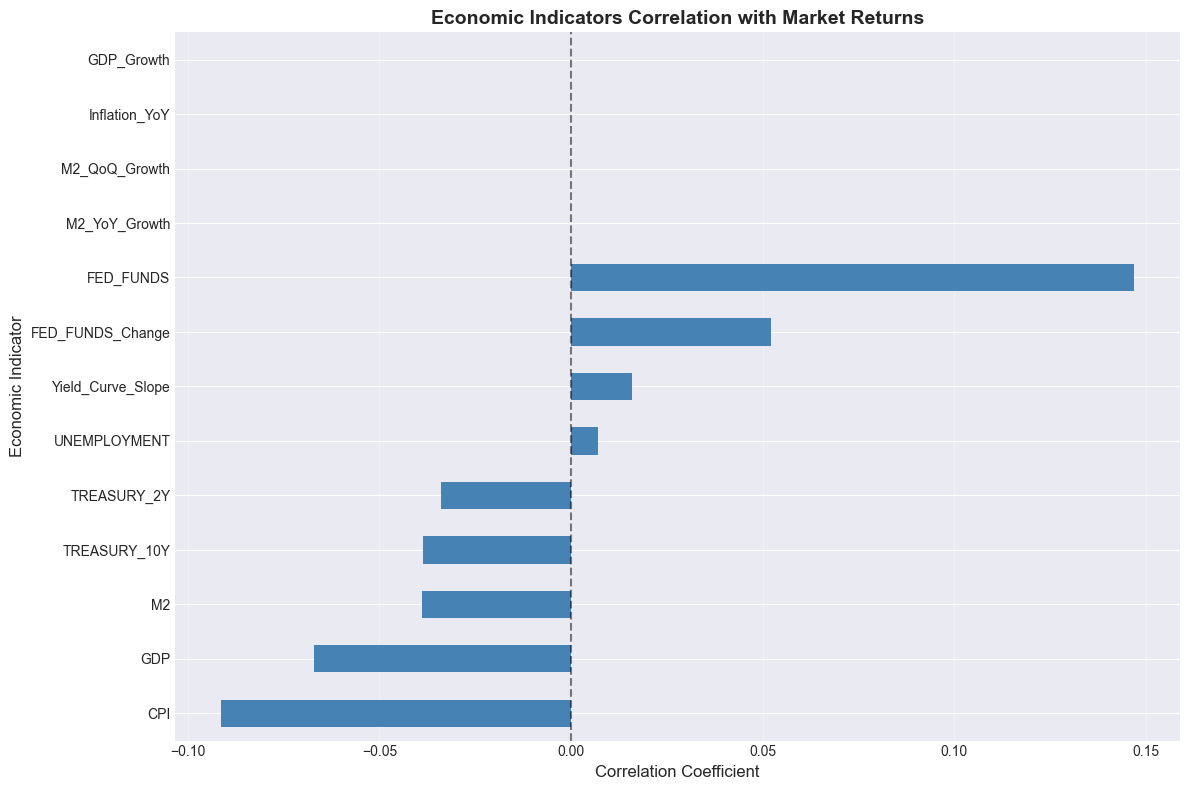

In [23]:
# Calculate correlations between economic factors and market returns
correlations = analysis_df.corr()['Market_Return'].sort_values(ascending=False)

print("Correlation with Market Returns:")
print(correlations)
print("\n" + "="*60)
print("Top Positive Correlations:")
print(correlations.drop('Market_Return').head(5))
print("\nTop Negative Correlations:")
print(correlations.drop('Market_Return').tail(5))
print("="*60)

# Visualize correlations
plt.figure(figsize=(12, 8))
correlations.drop('Market_Return').sort_values().plot(kind='barh', color='steelblue')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Economic Indicator', fontsize=12)
plt.title('Economic Indicators Correlation with Market Returns', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

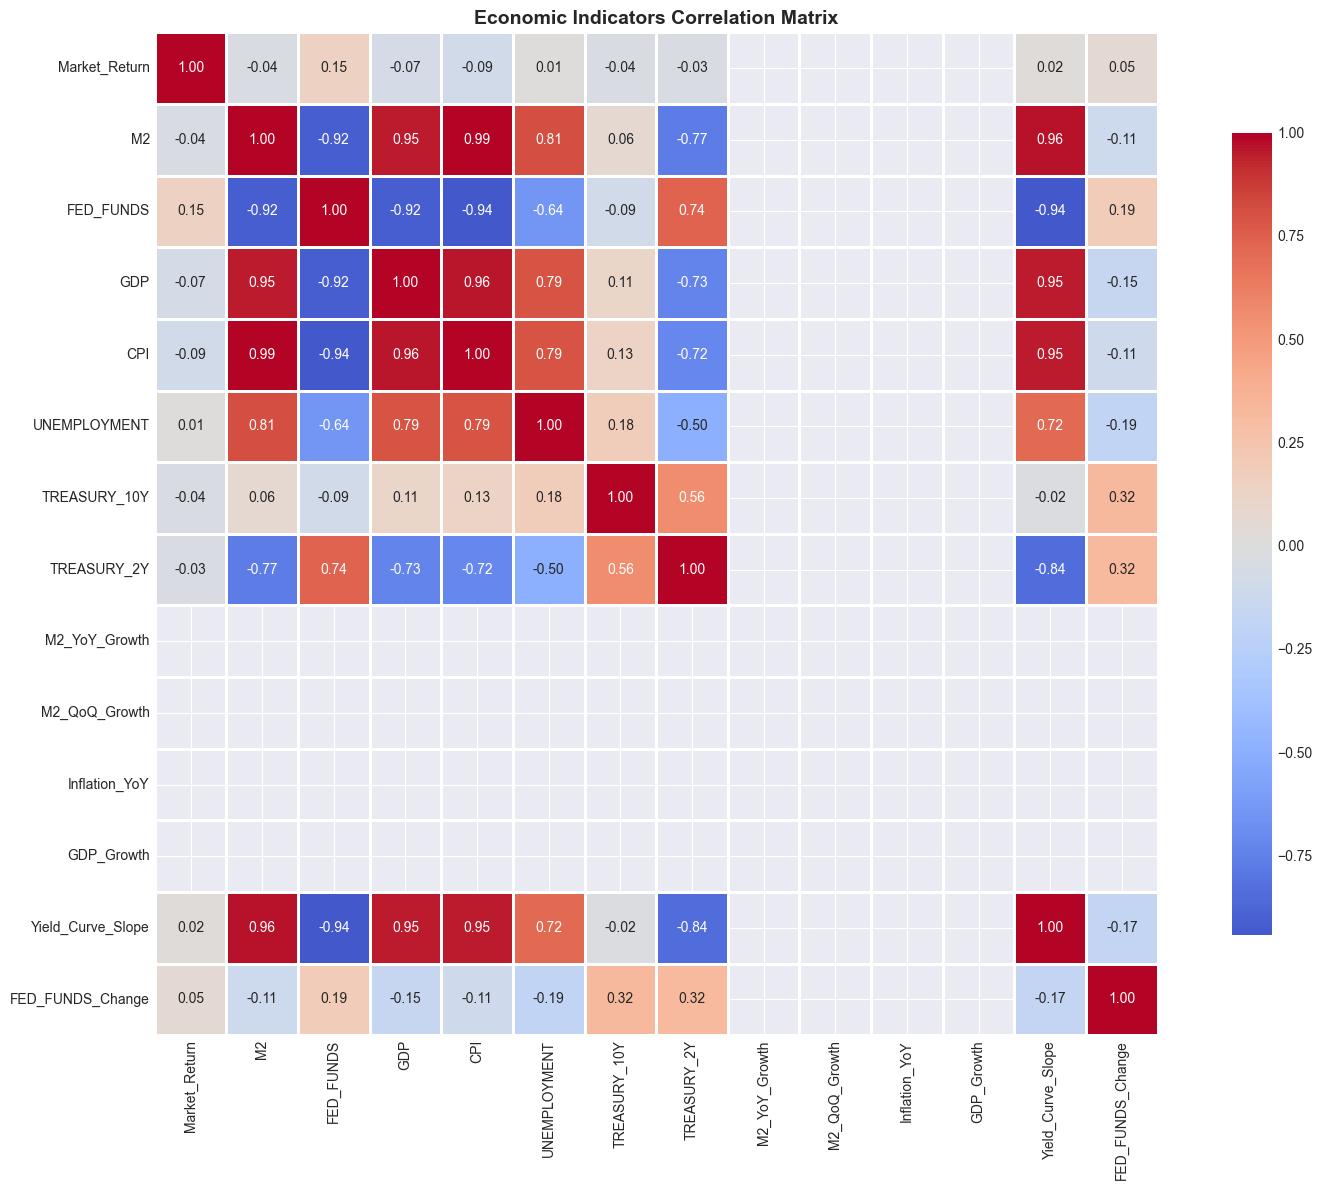

In [24]:
# Full correlation heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = analysis_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Economic Indicators Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Sector-Specific Analysis

In [26]:
# Analyze how each sector responds to economic factors
sector_correlations = {}

for sector in sector_returns_aligned.columns:
    sector_df = pd.concat([sector_returns_aligned[sector], economic_aligned], axis=1)
    
    # Only drop rows where sector return is NaN, then fill economic data
    sector_df = sector_df[sector_df[sector].notna()]
    sector_df = sector_df.fillna(method='ffill').fillna(method='bfill')
    
    if len(sector_df) > 10:  # Need at least 10 data points for correlation
        corr = sector_df.corr()[sector].drop(sector)
        sector_correlations[sector] = corr
        print(f"{sector}: {len(sector_df)} data points")

sector_corr_df = pd.DataFrame(sector_correlations)
print("\nSector correlations with economic factors:")
print(sector_corr_df.round(3))

XLK: 22 data points
XLV: 22 data points
XLF: 22 data points
XLI: 22 data points
XLY: 22 data points

Sector correlations with economic factors:
                     XLK    XLV    XLF    XLI    XLY
M2                 0.026  0.055 -0.234 -0.056 -0.212
FED_FUNDS          0.110  0.057  0.281  0.147  0.324
GDP               -0.027 -0.057 -0.173 -0.044 -0.191
CPI               -0.044  0.031 -0.264 -0.115 -0.260
UNEMPLOYMENT       0.080  0.088 -0.065  0.019 -0.064
TREASURY_10Y       0.041  0.162  0.012 -0.173 -0.085
TREASURY_2Y       -0.012  0.097  0.133 -0.091  0.097
M2_YoY_Growth        NaN    NaN    NaN    NaN    NaN
M2_QoQ_Growth        NaN    NaN    NaN    NaN    NaN
Inflation_YoY        NaN    NaN    NaN    NaN    NaN
GDP_Growth           NaN    NaN    NaN    NaN    NaN
Yield_Curve_Slope  0.042 -0.012 -0.152 -0.003 -0.172
FED_FUNDS_Change   0.059  0.229  0.017  0.027  0.188


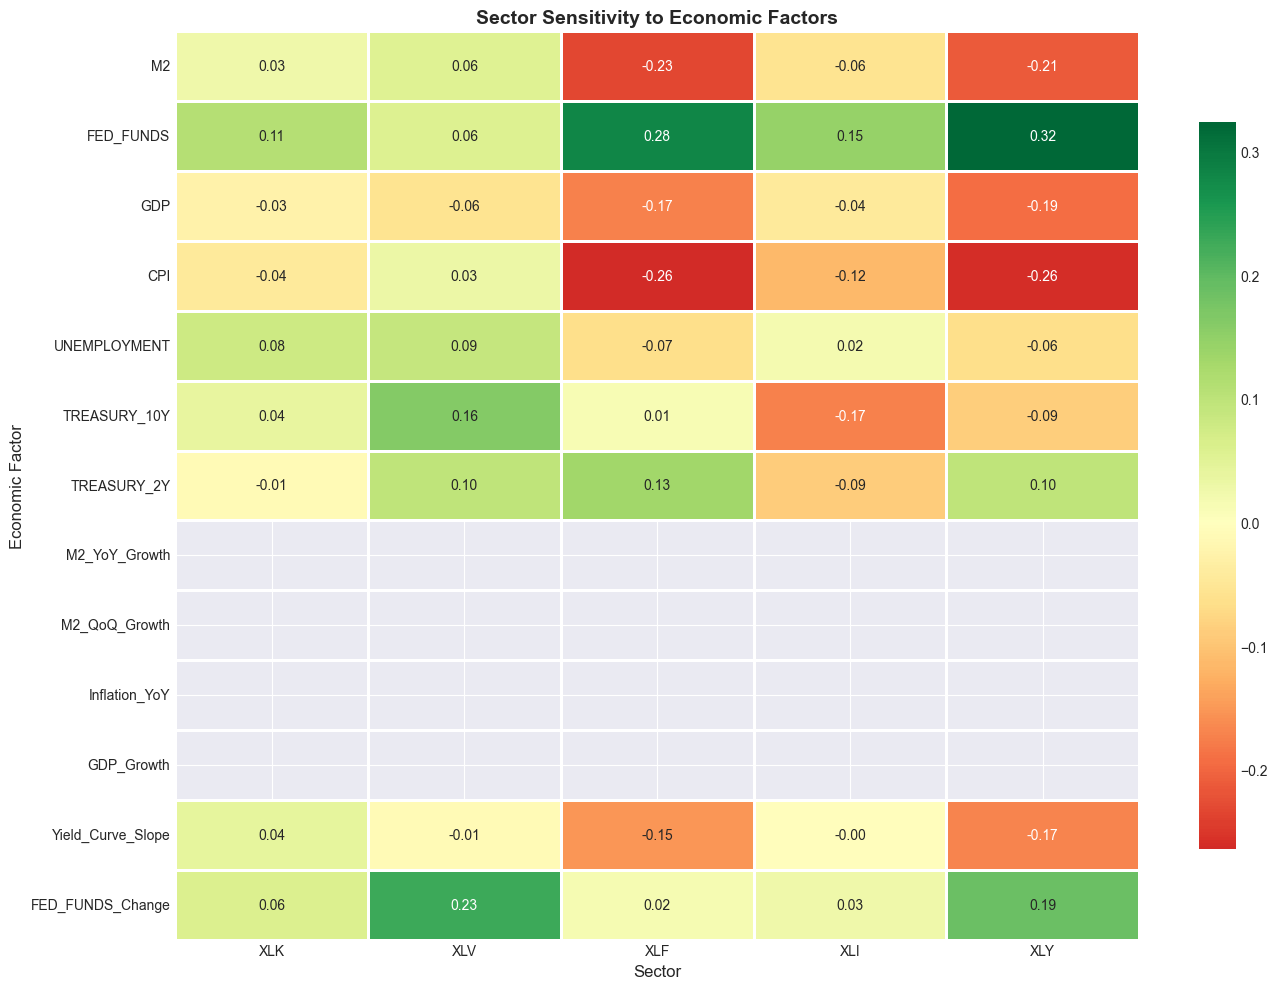

In [27]:
# Heatmap of sector sensitivities to economic factors
plt.figure(figsize=(14, 10))
sns.heatmap(sector_corr_df, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Sector Sensitivity to Economic Factors', fontsize=14, fontweight='bold')
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Economic Factor', fontsize=12)
plt.tight_layout()
plt.show()

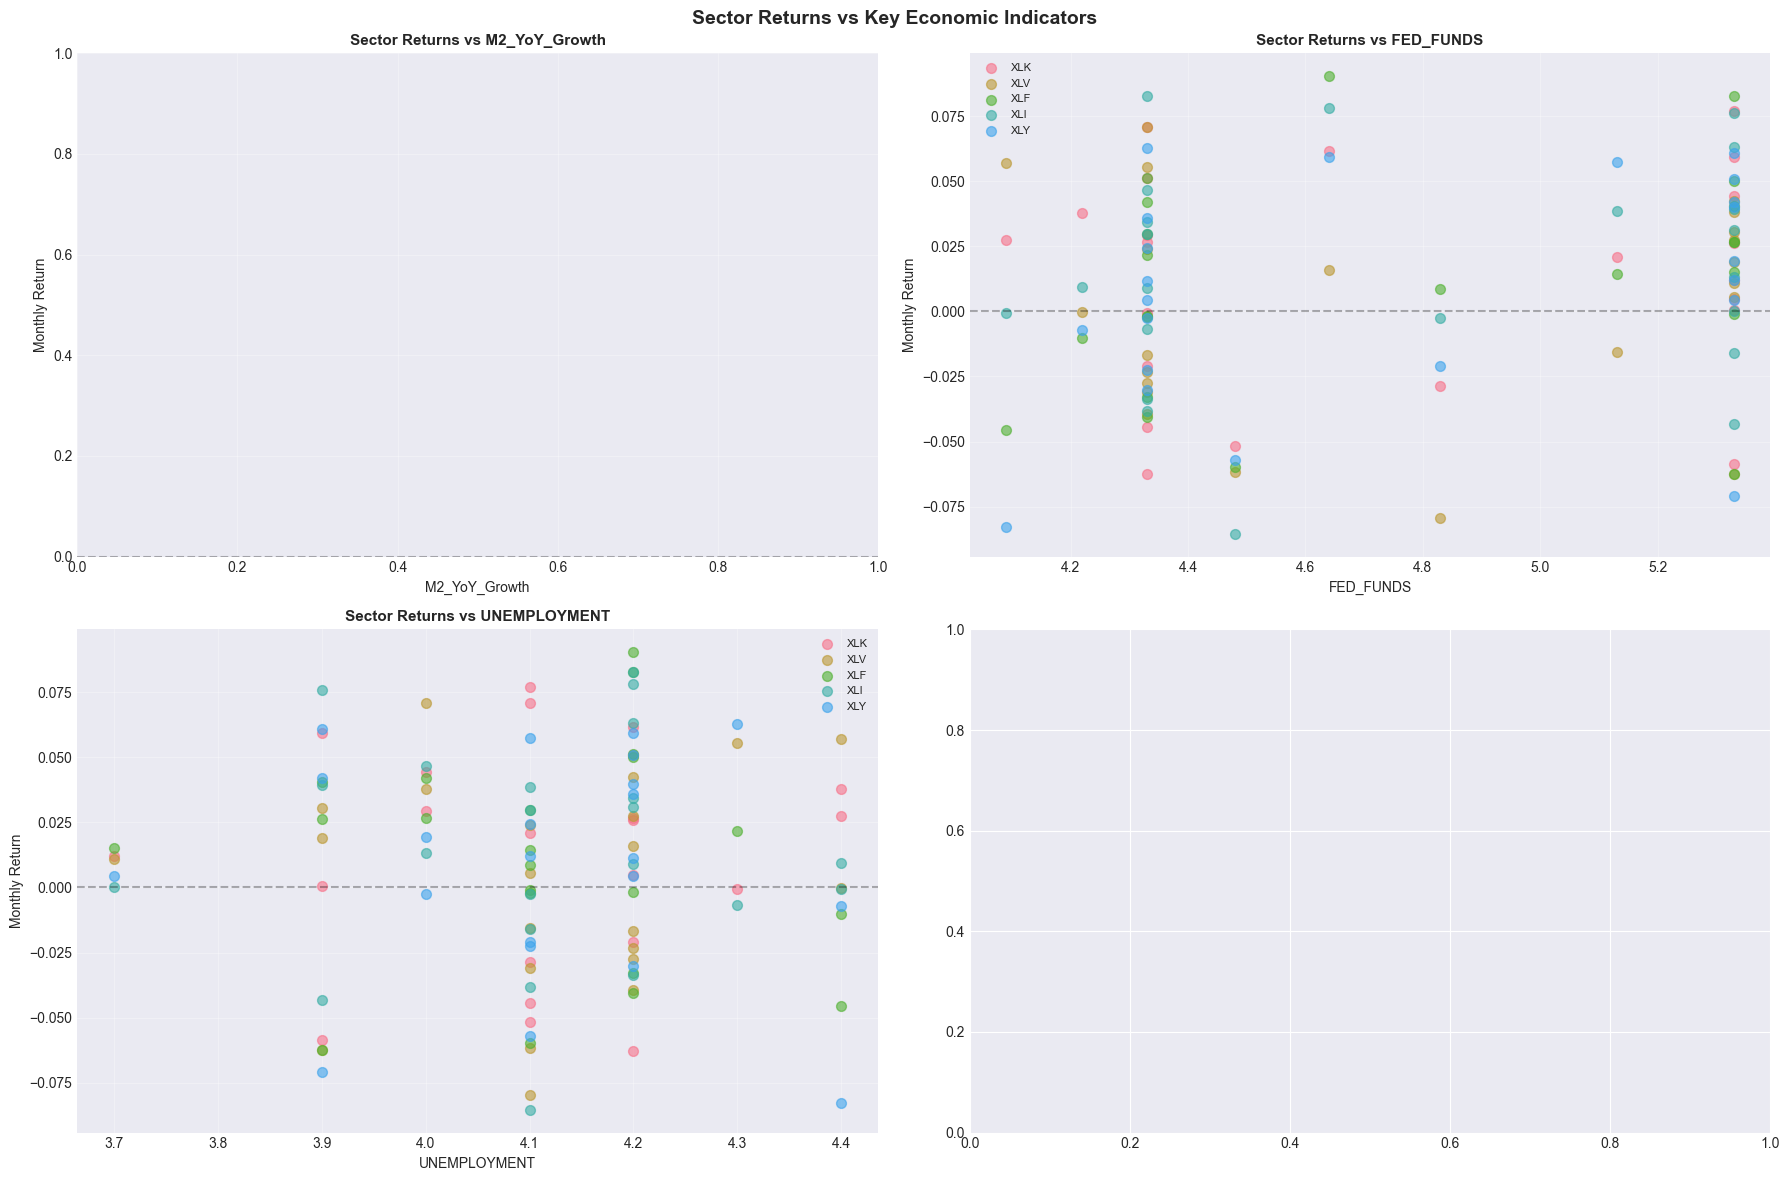

In [38]:
# Plot sector returns vs key economic indicators
key_indicators = ['M2_YoY_Growth', 'FED_FUNDS', 'UNEMPLOYMENT', 'VIX']
available_indicators = [ind for ind in key_indicators if ind in economic_aligned.columns]

if available_indicators:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, indicator in enumerate(available_indicators[:4]):
        ax = axes[idx]
        
        for sector in sector_returns_aligned.columns:
            # Create temporary dataframe for this sector and indicator
            temp_df = pd.concat([sector_returns_aligned[sector], economic_aligned[indicator]], axis=1)
            
            # Only drop rows where sector or indicator is NaN
            temp_df = temp_df.dropna(subset=[sector, indicator])
            
            if len(temp_df) > 0:
                ax.scatter(temp_df[indicator], temp_df[sector], 
                          label=sector, alpha=0.6, s=50)
        
        ax.set_xlabel(indicator, fontsize=10)
        ax.set_ylabel('Monthly Return', fontsize=10)
        ax.set_title(f'Sector Returns vs {indicator}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    plt.suptitle('Sector Returns vs Key Economic Indicators', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()